<a href="https://colab.research.google.com/github/tronghieu2810/COMPUTER_VISION/blob/main/UDM_Lazy_Programmer_Inc_De_Le_Ad_Co_Vi/SSD_Tensorflow_2_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Beginner Warning

This is dependent on a separate library which is not part of Tensorflow (but still made by the Tensorflow team).

Some beginners got "stuck" in the past when Tensorflow 2 came out, but this library was not compatible with Tensorflow 2.

Beginners often feel uncomfortable using older versions of libraries. This is *not* how things work in the real world.

See "Why bad programmers always need the latest version": https://youtu.be/BIXH_m6CT2I

## Clone Tensorflow Models Repository

In [8]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [9]:
! cd models

In [10]:
!ls

models	sample_data


## Install Protobuf

No need to do this if you are on Colab.

If you're doing this locally, download the latest Protobuf library for your OS from https://github.com/google/protobuf/releases

The filename should look like "protoc-\*-\*.zip".

Example: protoc-3.17.3-win64.zip if you are using 64-bit Windows.

Assuming you've unzipped this zip file to \<path\>, the next step is to add \<path\>/bin to your PATH environment variable (on Linux or Mac).

Once Protobuf has been successfully installed, you can run the following command (note: must be done from the models/research folder).

In [11]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

## Install the object detection API

In [12]:
!cd models/research && \
    cp object_detection/packages/tf2/setup.py . && \
    python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached avro-python3-1.10.2.tar.gz (38 kB)
  Using cached apache_beam-2.37.0-cp37-cp37m-manylinux2010_x86_64.whl (10.1 MB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached lvis-0.5.3-py3-none-any.whl (14 kB)
  Using cached tf_models_official-2.8.0-py2.py3-none-any.whl (2.2 MB)
  Using cached tensorflow_io-0.24.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (23.4 MB)
  Using cached sacrebleu-2.0.0-py3-none-any.whl (90 kB)
  Using cached tensorflow_addons-0.16.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl 

## Test Installation (Optional)

In [13]:
# !cd models/research && python object_detection/builders/model_builder_tf2_test.py

## Import Libraries

In [14]:
import os
import pathlib
import tensorflow as tf
import time
from   object_detection.utils import label_map_util
from   object_detection.utils import visualization_utils as viz_utils
import numpy as np
from   PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Download Images

In [16]:
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/jungle.jpeg
!wget -nc https://lazyprogrammer.me/course_files/object_detection_images/intersection.jpeg

--2022-03-16 23:11:27--  https://lazyprogrammer.me/course_files/object_detection_images/walkingdog.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195368 (191K) [image/jpeg]
Saving to: ‘walkingdog.jpeg’

walkingdog.jpeg     100%[===================>] 190.79K  --.-KB/s    in 0.02s   

2022-03-16 23:11:27 (8.20 MB/s) - ‘walkingdog.jpeg’ saved [195368/195368]

--2022-03-16 23:11:27--  https://lazyprogrammer.me/course_files/object_detection_images/traffic.jpeg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160514 (157K) [image/jpeg]
Saving to: ‘traffic.jpeg’

traffic.jpeg        10

In [17]:
!ls

intersection.jpeg  models	traffic.jpeg
jungle.jpeg	   sample_data	walkingdog.jpeg


In [18]:
IMAGE_PATHS = ['intersection.jpeg', 'traffic.jpeg', 'jungle.jpeg', 'walkingdog.jpeg']

## Download and extract model files

Get URLs from the "Object Detection Zoo": https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [19]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

# Download the model file
PATH_TO_MODEL_DIR = tf.keras.utils.get_file(fname='ssd_resnet101_v1_fpn_640x640_coco17_tpu-8', origin=url, untar=True)

386539520/386527459 [==============================] - 3s 0us/step


In [20]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'

## Download Labels File

Label files can be found here: https://github.com/tensorflow/models/tree/master/research/object_detection/data

You probably won't need these since Object Detection Zoo contains only models trained on COCO.

In [21]:
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt'

PATH_TO_LABELS = tf.keras.utils.get_file(fname='mscoco_label_map.pbtxt', origin=url, untar=False)
PATH_TO_LABELS

16384/5056 [=================================================================================================] - 0s 0us/step


'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [22]:
!head {PATH_TO_LABELS}

item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}


## Load in the model

In [23]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + '/saved_model'

print('Loading model --- ', end='')
start_time = time.time()

# Load saved model & build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()

elapsed_time = end_time - start_time
print(f'{elapsed_time} seconds.')

Loading model --- 43.24270009994507 seconds.


## Load in the labels

In [24]:
category_index = label_map_util.create_category_index_from_labelmap(label_map_path=PATH_TO_LABELS, use_display_name=True)
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Helper function

In [25]:
## Helper function

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

## Do some object detection

In [26]:
def detect_objects(image_path):
    print(f"Running inference for '{image_path}'")

    image_np = load_image_into_numpy_array(image_path)

    # The input needs to be a Tensor
    input_tensor = tf.convert_to_tensor(image_np)

    # The model expects a batch of images (N * Height * Width * 3)
    input_tensor = input_tensor[tf.newaxis, ...]

    # Do the detection
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors
    # Convert to Numpy arrays, take index [0] to remove the batch dimension
    # We're only interested in the first dimension
    num_detections = int(detections.pop('num_detections'))
    detections     = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # Detection_classes should be ints
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    # Show classes
    unique_classes = set(detections['detection_classes']) # Cast a class array to a set
    print('Classes found:')
    for c in unique_classes:
        print(f"- {category_index[c]['name']}")
    
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image=image_np_with_detections,
        boxes=detections['detection_boxes'],
        classes=detections['detection_classes'],
        scores=detections['detection_scores'],
        category_index=category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.30,
        agnostic_mode=False
    )

    plt.figure(figsize=(15, 10))
    plt.imshow(image_np_with_detections)
    print('Done!')
    plt.show()

Running inference for 'intersection.jpeg'
Classes found:
- potted plant
- person
- bicycle
- car
- frisbee
- motorcycle
- truck
- traffic light
- stop sign
- parking meter
- elephant
Done!


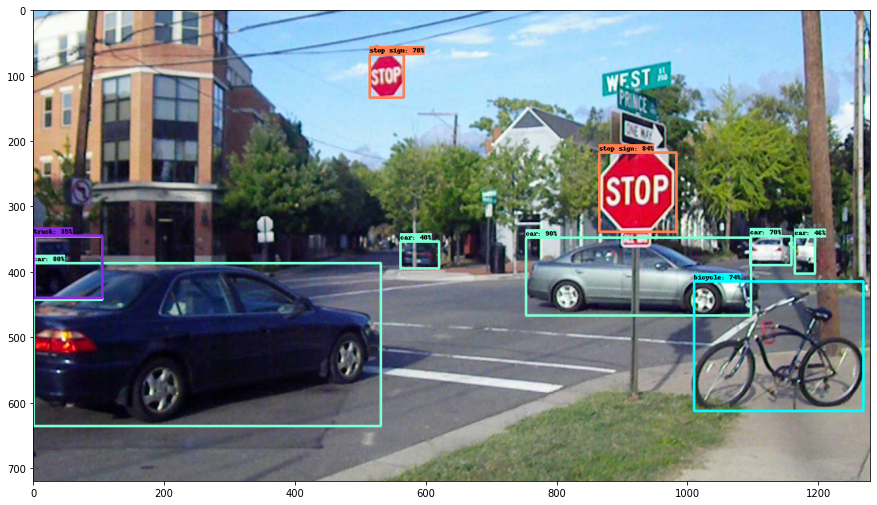

In [27]:
detect_objects(IMAGE_PATHS[0])

Running inference for 'traffic.jpeg'
Classes found:
- potted plant
- person
- bicycle
- car
- tie
- bus
- truck
- vase
Done!


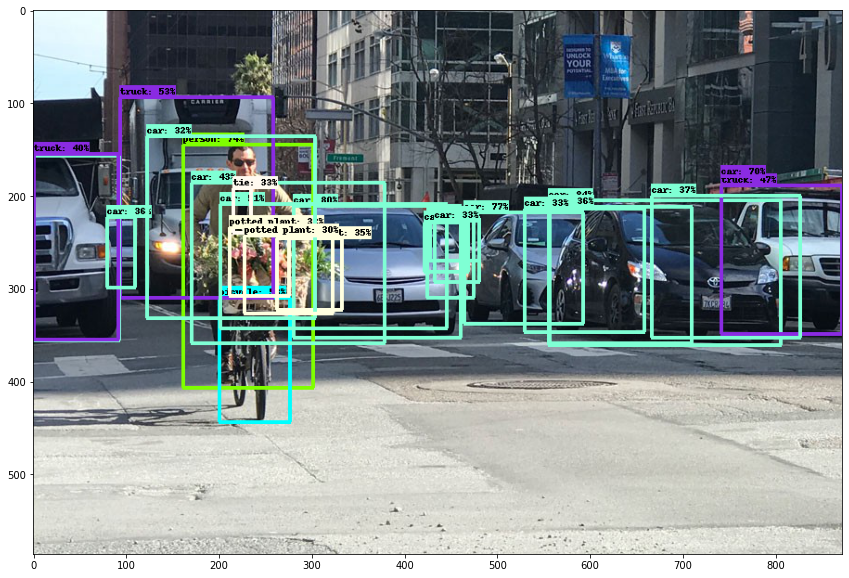

In [28]:
detect_objects(IMAGE_PATHS[1])

Running inference for 'jungle.jpeg'
Classes found:
- person
- train
- fire hydrant
- parking meter
- bench
- bird
- cat
- dog
- horse
- sheep
- cow
- elephant
- bear
- zebra
- giraffe
- sports ball
- baseball glove
- skateboard
- surfboard
- banana
- sandwich
- donut
- cake
- potted plant
- toilet
- teddy bear
Done!


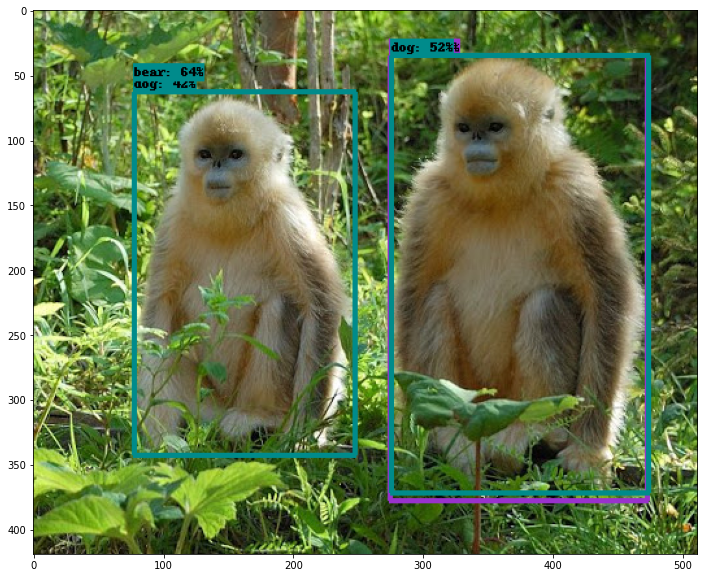

In [29]:
detect_objects(IMAGE_PATHS[2])

Running inference for 'walkingdog.jpeg'
Classes found:
- person
- bicycle
- bench
- cat
- dog
- horse
- sheep
- cow
- backpack
- handbag
- frisbee
- sports ball
- baseball bat
- baseball glove
- skateboard
- tennis racket
- bottle
- wine glass
- cup
- potted plant
- remote
- cell phone
- clock
Done!


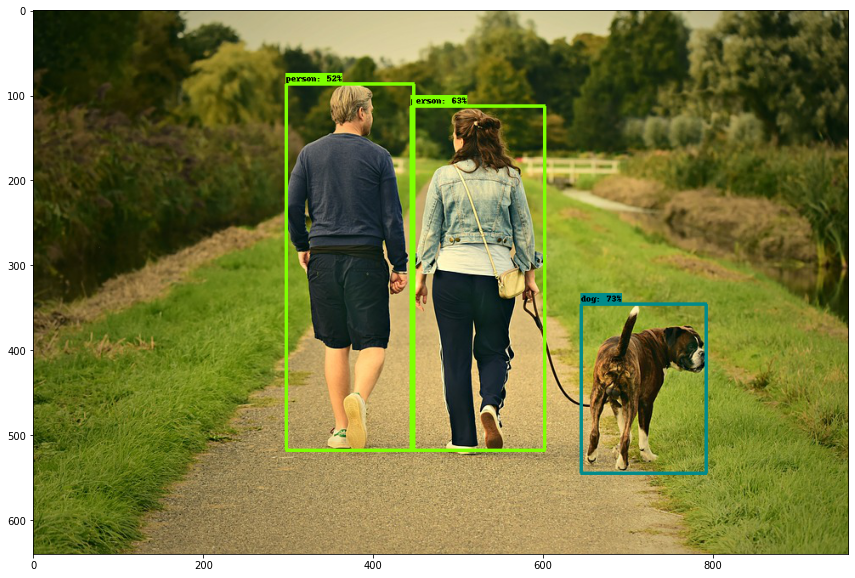

In [30]:
detect_objects(IMAGE_PATHS[3])